In [0]:
# Imports 
import glob, os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter


In [0]:
! git clone https://github.com/tyiannak/pyAudioAnalysis.git

Cloning into 'pyAudioAnalysis'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 2278 (delta 36), reused 44 (delta 17), pack-reused 2209
Receiving objects: 100% (2278/2278), 134.56 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (1391/1391), done.


[source article](https://walczak.org/2019/02/automatic-splitting-audio-files-silence-python/)

[source github](https://github.com/tyiannak/pyAudioAnalysis)

In [2]:
# Install the requirements from the Audio Analysis Paper 
! pip install -r /content/pyAudioAnalysis/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/pyAudioAnalysis/requirements.txt'


In [2]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm -rf wav 
!unzip  '/content/drive/My Drive/virufy/Data Collection/confidential data/wav files/*.zip' -d wav

In [3]:
# Read in the labeled structured data from the de-identified .CSV
text_df = pd.read_excel('/content/drive/My Drive/virufy/Data Collection/confidential data/cleaned data/pos-neg-only.xlsx')
text_df.shape



FileNotFoundError: ignored

In [0]:
# Map each spectrogram to the appropriate label
#text_df['cough_filename'] = text_df['cough_filename'].astype('str') 
#remove detect-now URL
text_df['cough_filename'] = text_df['cough_filename'].str[57:]

text_df.head()

In [0]:
# Convert to spectrograms
def get_spec_info(text_df):
  src_dir = "/content/wav/"
  sample_rate_list = []
  samples_list = []
  frequencies_list = []
  times_list = []
  spectrogram_list = []
  x_list = []
  sr_list = []
  y_label_list = []
  text_df_array = np.asarray(text_df['cough_filename'])
  print(text_df_array.shape)

  for index, row in text_df.iterrows():
    file = row['cough_filename']
    print(file)
    print('Making spectrogram for file: ', file)
    sample_rate, samples = wavfile.read(src_dir + file)
    x, sr = librosa.load(src_dir + file, sr=sample_rate)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    sample_rate_list.append(sample_rate)
    samples_list.append(samples)
    frequencies_list.append(frequencies)
    times_list.append(times)
    spectrogram_list.append(spectrogram)
    x_list.append(x)
    sr_list.append(sr)

    if row['corona_test'] == 'NEGATIVE':
      y_label_list.append(0)
    elif row['corona_test'] == 'POSITIVE':
      y_label_list.append(1)
    else:
      raise Exception('Invalid label: ' + row['corona_test'])
        
  return sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list , y_label_list

In [0]:
sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list , y_label_list = get_spec_info(text_df)

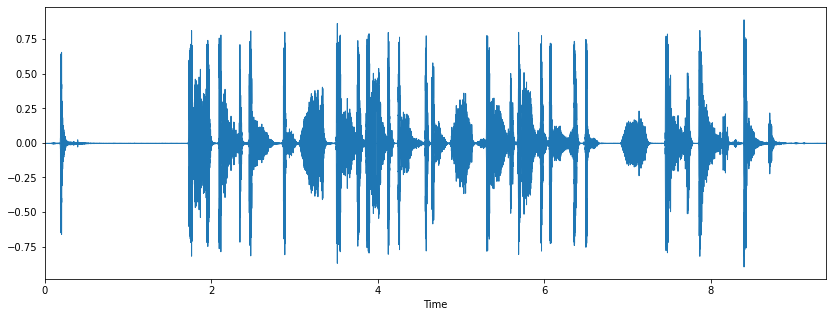

In [0]:
#plt.pcolormesh(times_list[79], frequencies_list[79], spectrogram_list[79])
#plt.ylim(0,4000)

# Plot one of the coughs before removing silence
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_list[0], sr=sr_list[0])

In [0]:
# Remove silences in the cough files 
# TO DO: This is not working... the audio still has silence in it!
src_dir = "/content/wav" # source directory path
for file in sorted(glob.glob(f"{src_dir}/*.wav")):
    print("#"*40)
    print(file)
    src_code = "/content/pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py" # running using the sourcecode 
    os.system(f"python {src_code} silenceRemoval -i " + file + " --smoothing 0.2 --weight 0.1")

In [0]:
sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list, y_label_list = get_spec_info(text_df)

In [0]:
#TO DO: Figure out how to remove the silences from the file itself
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_list[0], sr=sr_list[0])

(1025, 881)


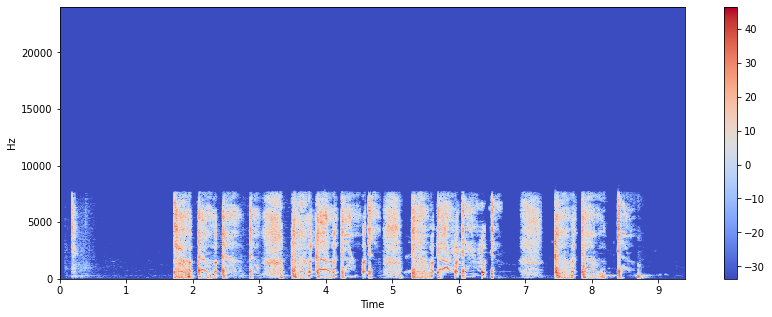

In [0]:
# Plot the spectrogram
X = librosa.stft(x_list[0])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr_list[0], x_axis='time', y_axis='hz')
plt.colorbar()
print(Xdb.shape)


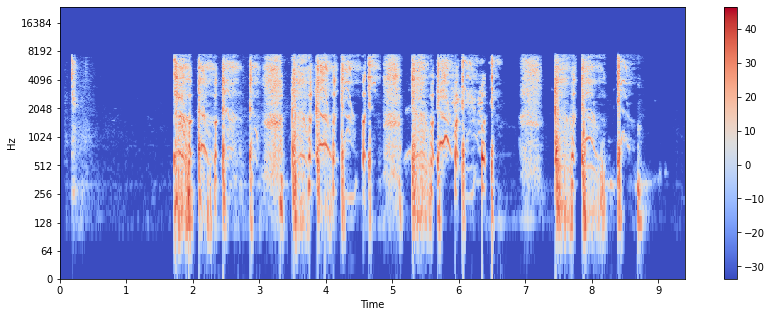

In [0]:
# Log Transform the Spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr_list[0], x_axis='time', y_axis='log')
plt.colorbar()

(20, 881)


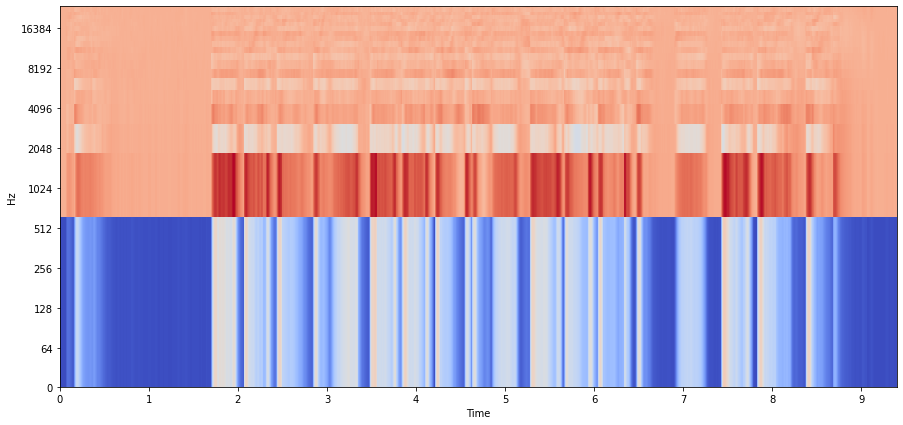

In [0]:
# Retrieve the MFCC coefficients & Plot

mfccs = librosa.feature.mfcc(x_list[0], sr=sr_list[0])
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr_list[0], x_axis='time' , y_axis='log')
plt.colorbar()

In [0]:
# Get a Chroma feature or vector indicating how much energy of each pitch class 
# This is used often in music for matching music via pitch

chromagram = librosa.feature.chroma_stft(x_list[0], sr=sr_list[0])
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()

NameError: ignored

In [0]:
# Apply a Butterworth Filter (Look into try other types of filters)?

#def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):

#    nyquist_freq = 0.5 * signal_freq
#   low = lowcut / nyquist_freq
#    high = highcut / nyquist_freq
#    b, a = butter(filter_order, [low, high], btype="band")
#    y = lfilter(b, a, data)
#    return y


#filtered_audio = bandpass_filter(x_list[0] , 20 , 20000 , sr_list[0] , 1)

In [0]:
# TO DO


# - Remove silences

# - Store features into the appropriate data structure

# - Extract features such as pitch, tempo, etc

